# Version information

In [8]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: June 03, 2022
Pyleecan version:1.3.7
SciDataTool version:1.4.24


In [9]:
%matplotlib notebook

# Load the machine
from os.path import join
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR



# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

In [10]:

from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent

from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D
from pyleecan.definitions import DATA_DIR


"""Validation of the AGSF spectrum calculation for IPMSM machine with symmetries"""
# Test 2 : With sym

# Load machine
Toyota_Prius = load('D:\KDH\Toyota_Prius.json')
Toyota_Prius.plot()

<IPython.core.display.Javascript object>

In [11]:
# Prepare simulation
simu2 = Simu1(name="IPMSM_AGSF_spectrum_sym", machine=Toyota_Prius)

simu2.input = InputCurrent(
    OP=OPdq(Id_ref=0, Iq_ref=0, N0=1500),
    Ir=None,
    Na_tot=2 ** 6, #Angle : 64
    Nt_tot=4 * 2 ** 4, #Time :4096
)

simu2.elec = None

simu2.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
)
simu2.force = ForceMT(
    is_periodicity_a=True,
    is_periodicity_t=True,
)

simu2.mag.is_periodicity_a = True #?
simu2.mag.is_periodicity_t = True #?

simu2.force.is_periodicity_a = True # ?
simu2.force.is_periodicity_t = True # ?


simu2.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu2.mag.is_save_meshsolution_as_file = True # To save FEA results in a dat file


simu2.mag.nb_worker = 4
out = simu2.run()




AGSF = out.force.AGSF


## time_to_freq reversibility
arg_list = ["time", "angle"]
result = AGSF.get_rphiz_along(*arg_list)
Prad = result["radial"]
time = result["time"]
angle = result["angle"]
Xangle, Xtime = meshgrid(angle, time)

# Check time_to_freq reversibility
AGSF_rad_freq = AGSF.components["radial"].time_to_freq()
result_frq = AGSF_rad_freq.get_along(*arg_list)
Prad_frq = result_frq["AGSF_r"]


AGSF2 = AGSF_rad_freq.freq_to_time()
result2 = AGSF2.get_along(*arg_list)
Prad2 = result2["AGSF_r"]

# Check time-space reconstruction
arg_list = ["freqs", "wavenumber"]
result_freq = AGSF.get_rphiz_along(*arg_list)
Prad_wr = result_freq["radial"]
freqs_AGSF = result_freq["freqs"]
wavenumber = result_freq["wavenumber"]
Nf = len(freqs_AGSF)
Nr = len(wavenumber)




[19:15:51] Starting running simulation IPMSM_AGSF_spectrum_sym (machine=Toyota_Prius)
[19:15:51] Starting Magnetic module
[19:15:52] Solving time step 3 / 8 in FEMM
[19:15:52] Solving time step 5 / 8 in FEMM
[19:15:53] Solving time step 1 / 8 in FEMM
[19:15:53] Solving time step 7 / 8 in FEMM
[19:15:54] Solving time step 6 / 8 in FEMM
[19:15:54] Solving time step 4 / 8 in FEMM
[19:15:54] Solving time step 2 / 8 in FEMM
[19:15:54] Solving time step 8 / 8 in FEMM
[19:15:55] Starting Force module
[19:15:55] End of simulation IPMSM_AGSF_spectrum_sym


In [12]:
out.mag.meshsolution.plot_contour(label="B", clim=[0,2])

#group_names="Stator Core"
#,is_animated=True,is_show_fig=False,
        # save_path="D:\plot_mesh_stator.gif"

## Data Check

In [13]:
out.mag.B.plot_3D_Data("time[smallestperiod]", "angle[smallestperiod]{°}", is_2D_view=True)



<IPython.core.display.Javascript object>

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B50E5B9A0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B50E5B9A0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


<IPython.core.display.Javascript object>

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B50EE0A00>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B50EE0A00> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


In [14]:
out.mag.B.plot_2D_Data("time")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
out.mag.B.plot_2D_Data("angle{°}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 공간 자속밀도분포(공극)

In [ ]:
6

82.00891658838079

In [16]:
# Check time-space reconstruction
print('Number of freqs_AGSF:',Nf)
print('wavenumber:',Nr)
# print(' ["freqs", "wavenumber"]=',arg_list)#
# print('AGSF.get_rphiz_along(*arg_list):',result_freq)
# print('result_freq["radial"]',Prad_wr)
print('result_freq["freqs"]:',freqs_AGSF)
print('result_freq["wavenumber"]',wavenumber)


Number of freqs_AGSF: 5
wavenumber: 8
result_freq["freqs"]: [  0. 200. 400. 600. 800.]
result_freq["wavenumber"] [-32 -24 -16  -8   0   8  16  24]


In [17]:
out.mag.B.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D
)
out.mag.B.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B54A25970>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000023B54A25970> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


## 포스 모듈
Force 추상 클래스를 사용하면 힘을 계산하는 다양한 방법을 정의할 수 있습니다.

ForceMT 클래스는 Force 클래스에서 상속됩니다. ForceMT는 Maxwell 응력 텐서 \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]를 기반으로 하는 공극 표면력을 계산합니다.

여기서 우리는 힘 계산 없이 자기 시뮬레이션의 결과를 얻습니다. Force 모듈은 초기화되고 단독으로 실행됩니다.
시뮬레이션이 완료되면 결과가 출력의 force 부분(예: _myResults.force_ )에 저장되고 다른 플롯을 호출할 수 있습니다. 이 개체에는 다음이 포함됩니다.
- *시간*: 시간 축
- *각도*: 각도 위치 축
- *AGSF*: 에어갭 표면력(방사형 및 접선 성분)
    
**출력** 개체는 결과를 쉽게 시각화하기 위해 다른 플롯을 포함합니다. 


c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:443: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, 

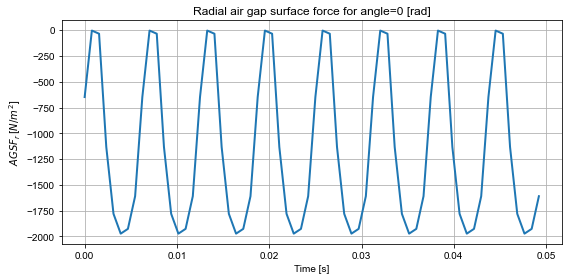

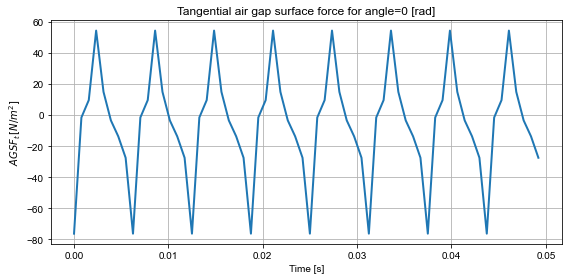

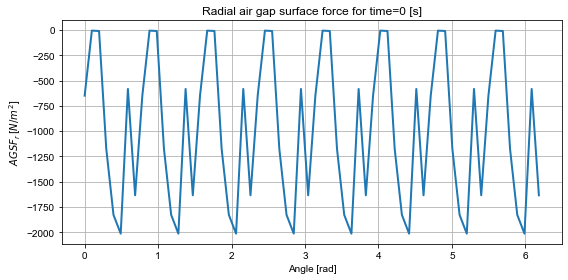

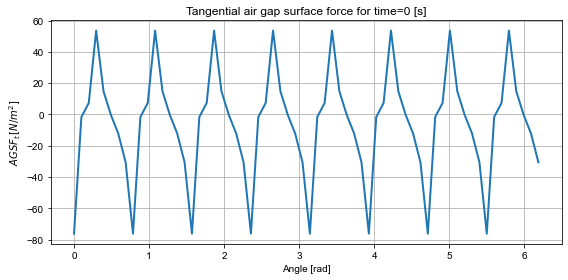

In [11]:
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Functions.Plot import dict_2D, dict_3D
import matplotlib.pyplot as plt


AGSF_rad_freq.plot_2D_Data_Animated("time",'angle',save_path="D:/AGSF.gif",)
#AGSF_rad_freq.plot_2D_Data("time")
AGSF.plot_2D_Data('time')
AGSF.plot_2D_Data('angle')


   

다음 플롯은 시간과 각도에 따른 방사형 에어 갭 표면력을 표시합니다.

c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:354: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pyleecan_v1\lib\site-packages\SciDataTool\Functions\Plot\plot_4D.py:271: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


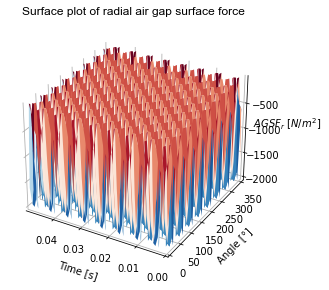

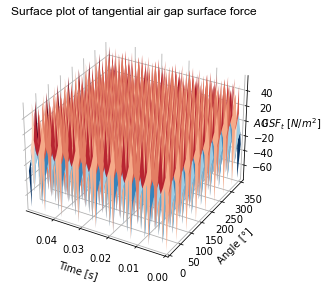

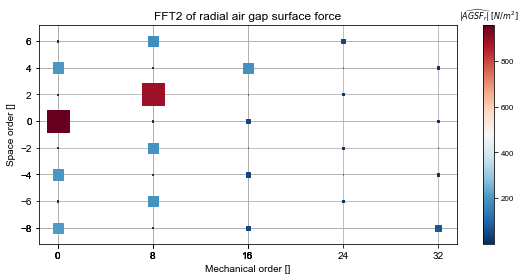

In [6]:
AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=False, **dict_3D)
AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    component_list=["radial"],
    is_2D_view=True,
    **dict_3D

)
#------------------------------------------------------

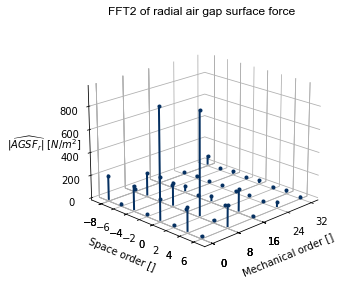

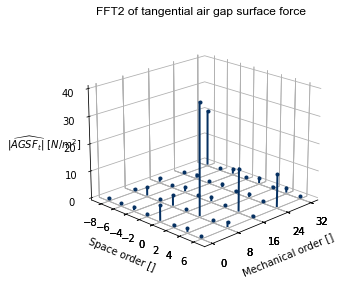

In [7]:
AGSF.plot_3D_Data(
    "freqs->mech_order=[0,96]",
    "wavenumber->space_order=[-48,48]",
    N_stem=100,
    
    #component_list=["radial"],
    is_2D_view=False,
    **dict_3D

)
#------------------------------------------------------

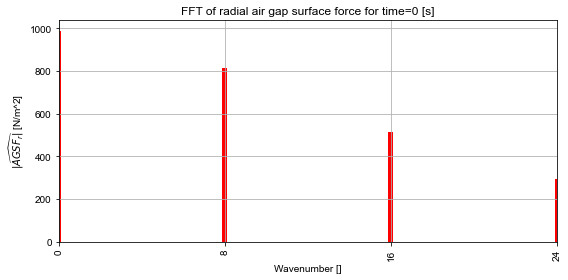

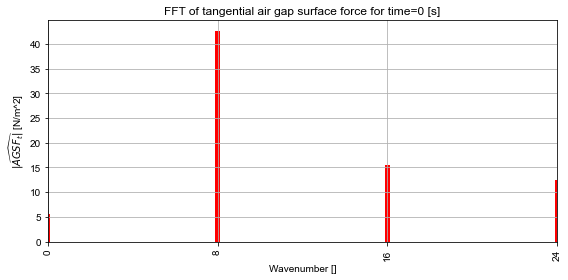

In [7]:
AGSF.plot_2D_Data("wavenumber=[0,78]", **dict_2D)

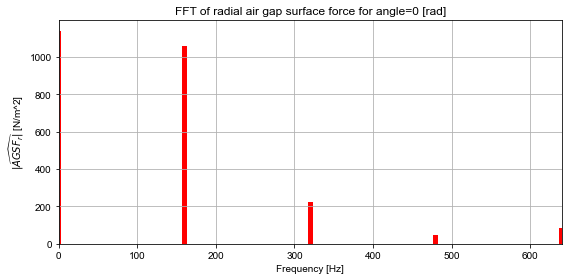

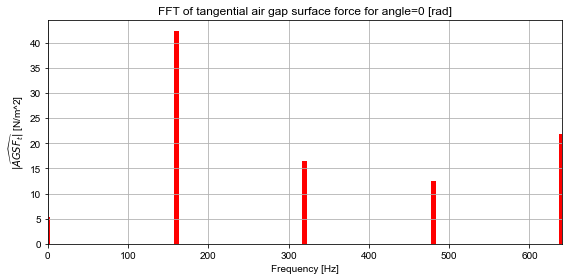

In [32]:
AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False, **dict_2D)


 
이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb)에서 볼 수 있습니다.